# Sentiment Analysis with Twitter API
- Name: Matt Song
- e-mail: songjoomyung@gmail.com

In [1]:
# import libraries
import pandas as pd
import numpy as np
import os
import json
import glob
from datetime import datetime

## Check vaderSentiment

In [2]:
# import object
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# create analyzer object
analyzer = SentimentIntensityAnalyzer()

# create function to output sentiment ratings
def print_sentiment_ratings(sentence):
    sent = analyzer.polarity_scores(sentence)
    print("{} {}".format(sentence, sent))

In [3]:
print_sentiment_ratings("I have to work on the weekend")

I have to work on the weekend {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


## Tweepy 

### Create Connection to Twitter

In [4]:
# import api keys
from config import consumer_key, consumer_secret, access_token, access_token_secret

# import tweepy
import tweepy

In [5]:
# authenticate with Twitter
authen = tweepy.OAuthHandler(consumer_key, consumer_secret)
authen.set_access_token(access_token, access_token_secret)

# connect to Twitter
tweetapi = tweepy.API(authen)

### Pull Data from Twitter

In [6]:
# get tweets for 7 days
tweets_7_days = tweetapi.search_tweets('tesla')
print(f'Retrieved {len(tweets_7_days)} tweets for the last 7 days')

Retrieved 15 tweets for the last 7 days


In [7]:
# get tweets for 30 days (limited to use 250 time monthly)
tweets_30_days = tweetapi.search_30_day(label='test', query='tesla')

print(f'Retrieved {len(tweets_30_days)} tweets for the last 30 days')

Retrieved 100 tweets for the last 30 days


In [9]:
# Start and end times must be in UTC
from tracemalloc import start

start_time = '202201010000'
end_time = '202204302359'

# get tweets in full archive (limited to use 50 times monthly)
tweets_full_archive = tweetapi.search_full_archive(label='test', 
    query='tesla', 
    fromDate=start_time, toDate=end_time, 
    maxResults=100
)
print(f'Retrieved {len(tweets_full_archive)} tweets from {start_time} to {end_time}')

Retrieved 100 tweets from 202201010000 to 202204302359


### Create DataFrame with Sentiment Scores of Tweets

In [10]:
# Iterate through the tweets that have been retrieved
# Append VADER sentiment scores

tweet_id = []
tweet_lang = []
tweet_created_at = []
tweet_retweet_count = []
tweet_text = []

tweet_sentiment_score = []
sentiment_df = pd.DataFrame(columns=\
  ['id', 'lang', 'created_at', 'retweet_count',
   'text' ,'sentiment_score'])

for tweet in tweets_30_days:
    analyzer = SentimentIntensityAnalyzer()

    tweet_id.append(str(tweet.id))
    tweet_lang.append(str(tweet.lang))
    tweet_created_at.append(str(tweet.created_at))
    tweet_retweet_count.append(str(tweet.retweet_count))    
    tweet_text.append(str(tweet.text))

    tweet_sentiment_score.append(str(analyzer.polarity_scores(tweet.text)["compound"]))

sentiment_df['id'] = tweet_id
sentiment_df['lang'] = tweet_lang
sentiment_df['created_at'] = tweet_created_at
sentiment_df['retweet_count'] = tweet_retweet_count
sentiment_df['text'] = tweet_text

sentiment_df['sentiment_score'] = tweet_sentiment_score

sentiment_df['text'] = sentiment_df['text'].str.replace('\n', ' ')

# Create a positive / negative sentiment variable
sentiment_df['sentiment'] = np.where(sentiment_df['sentiment_score'].astype(np.float) > 0, 'Positive', 'Negative')
sentiment_df['sentiment'] = np.where(sentiment_df['sentiment_score'].astype(np.float) == 0, 'Neutral', sentiment_df['sentiment'])

C:\Users\matt_song\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:37: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\matt_song\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [11]:
sentiment_df

,id,lang,created_at,retweet_count,text,sentiment_score,sentiment
0,1618388551435157506,en,2023-01-25 23:21:13+00:00,0,@ldragoon @davidnotdave @Tesla Nah. That’d be ...,-0.1027,Negative
1,1618388548591439872,en,2023-01-25 23:21:12+00:00,0,RT @WatcherGuru: JUST IN: Elon Musk says Tesla...,0.5256,Positive
2,1618388547186327552,en,2023-01-25 23:21:12+00:00,0,RT @WatcherGuru: JUST IN: Elon Musk says Tesla...,0.5256,Positive
3,1618388546527834114,en,2023-01-25 23:21:12+00:00,0,RT @axios: Tesla reported record profit and re...,0.2382,Positive
4,1618388542467768320,en,2023-01-25 23:21:11+00:00,0,"RT @SawyerMerritt: BREAKING: @elonmusk says ""s...",0.5622,Positive
...,...,...,...,...,...,...,...
95,1618388381985275905,en,2023-01-25 23:20:33+00:00,0,RT @GailAlfarATX: COUNTDOWN TO TODAY’S EARNING...,0.0,Neutral
96,1618388381557219328,en,2023-01-25 23:20:33+00:00,0,Tesla Beats On Top And Bottom Line As Margins ...,0.2023,Positive
97,1618388372535508992,en,2023-01-25 23:20:30+00:00,0,RT @spectatorindex: BREAKING: Elon Musk says T...,0.5256,Positive
98,1618388366017368066,en,2023-01-25 23:20:29+00:00,0,#BREAKING: Elon Musk says Tesla will be the wo...,0.5256,Positive


In [12]:
sentiment_df.loc[1]

id                                               1618388548591439872
lang                                                              en
created_at                                 2023-01-25 23:21:12+00:00
retweet_count                                                      0
text               RT @WatcherGuru: JUST IN: Elon Musk says Tesla...
sentiment_score                                               0.5256
sentiment                                                   Positive
Name: 1, dtype: object

In [13]:
print(sentiment_df.text[1])

RT @WatcherGuru: JUST IN: Elon Musk says Tesla $TSLA will be the most valuable company in the world in the long run.


### Plot Sentiment Analysis over Time

In [15]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [16]:
sentiment_df[['created_at', 'sentiment_score']]

,created_at,sentiment_score
0,2023-01-25 23:21:13+00:00,-0.1027
1,2023-01-25 23:21:12+00:00,0.5256
2,2023-01-25 23:21:12+00:00,0.5256
3,2023-01-25 23:21:12+00:00,0.2382
4,2023-01-25 23:21:11+00:00,0.5622
...,...,...
95,2023-01-25 23:20:33+00:00,0.0
96,2023-01-25 23:20:33+00:00,0.2023
97,2023-01-25 23:20:30+00:00,0.5256
98,2023-01-25 23:20:29+00:00,0.5256


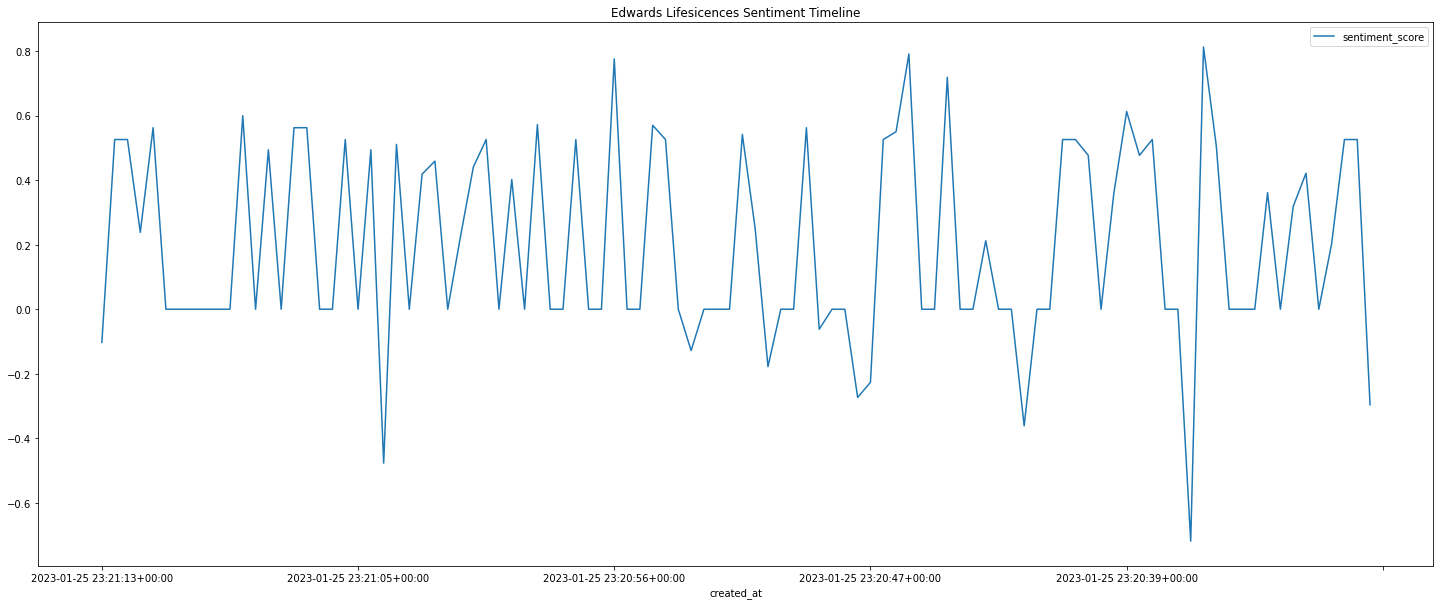

In [17]:
plt.rcParams['figure.figsize'] = (25, 10)

timeline_df = sentiment_df.copy()
timeline_df['sentiment_score'] = timeline_df['sentiment_score'].astype('float')
timeline_df = timeline_df[['created_at', 'sentiment_score']].set_index('created_at')

timeline_df.plot()
plot = plt.title('Edwards Lifesicences Sentiment Timeline')